In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/18 16:39:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/18 16:39:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/18 16:39:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
data_loc = "../data/tables/"
consumer = spark.read.parquet(data_loc+"consumer_user_details.parquet")
tbl_consumer = spark.read.csv(data_loc+"tbl_consumer.csv", sep="|", header=True)
tbl_merchant = spark.read.parquet(data_loc+"tbl_merchants.parquet")
transact1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
transact2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")
transact3 = spark.read.parquet("../data/tables/transactions_20220228_20220828_snapshot/")
transactions = transact1.union(transact2).union(transact3)

<h2> 1. Standardize column format of tables</h2>

<h3>1.1 "tbl_merchants.parquet"</h3>

In [3]:
tbl_merchant.show(5)

+--------------------+--------------------+------------+
|                name|                tags|merchant_abn|
+--------------------+--------------------+------------+
|       Felis Limited|((furniture, home...| 10023283211|
|Arcu Ac Orci Corp...|([cable, satellit...| 10142254217|
|    Nunc Sed Company|([jewelry, watch,...| 10165489824|
|Ultricies Digniss...|([wAtch, clock, a...| 10187291046|
| Enim Condimentum PC|([music shops - m...| 10192359162|
+--------------------+--------------------+------------+
only showing top 5 rows



In [4]:
# separate "tags" into "products", "revenue_level", "take_rate"
preprocessed_tbl_merchant = tbl_merchant.withColumn("split_tags", split(col("tags"), ",")) \
            .withColumn("take_rate", element_at(col("split_tags"), -1)) \
            .withColumn("revenue_level", element_at(col("split_tags"), -2)) \
            .withColumn("products", slice(reverse(col("split_tags")), 3, 100)) \
            .withColumn("products", reverse(col("products")))


In [5]:
# remove the special characters of "revenue_level" and "take_rate"
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("revenue_level", regexp_replace("revenue_level", "[^a-e]", "")) \
                                                     .withColumn("take_rate", regexp_replace("take_rate", "[^0-9.]", ""))

In [6]:
# standardize the values in "products" and vectorize "products" into the bags of word
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumn("products", concat_ws(",", col("products"))) \
                                                     .withColumn("products", regexp_replace("products", "[^A-Za-z0-9]", " ")) \
                                                     .withColumn("products", regexp_replace("products", "\s+", " ")) \
                                                     .withColumn("products", regexp_replace("products", "(^\s+)|(\s+$)", "")) \
                                                     .withColumn("products", lower(col("products"))) \
                                                     .withColumn("products", split(col("products"), " "))

In [7]:
preprocessed_tbl_merchant = preprocessed_tbl_merchant.withColumnRenamed("name", "merchant_name")
preprocessed_tbl_merchant = preprocessed_tbl_merchant.select("merchant_name", "products", "revenue_level",
                                                             preprocessed_tbl_merchant.take_rate.cast("double"), "merchant_abn")

In [8]:
preprocessed_tbl_merchant.show(5)

+--------------------+--------------------+-------------+---------+------------+
|       merchant_name|            products|revenue_level|take_rate|merchant_abn|
+--------------------+--------------------+-------------+---------+------------+
|       Felis Limited|[furniture, home,...|            e|     0.18| 10023283211|
|Arcu Ac Orci Corp...|[cable, satellite...|            b|     4.22| 10142254217|
|    Nunc Sed Company|[jewelry, watch, ...|            b|      4.4| 10165489824|
|Ultricies Digniss...|[watch, clock, an...|            b|     3.29| 10187291046|
| Enim Condimentum PC|[music, shops, mu...|            a|     6.33| 10192359162|
+--------------------+--------------------+-------------+---------+------------+
only showing top 5 rows



<h3>1.2 "transactions"</h3>

In [9]:
import time
import datetime
from pyspark.sql import SparkSession, functions as F

date = "2021-12-22"

date_time = datetime.datetime.strptime(date, '%Y-%m-%d')


In [10]:
transactions.where((F.col("merchant_abn") == 19492220327) & (F.col("order_datetime") == date_time.date()))

user_id,merchant_abn,dollar_value,order_id,order_datetime
15338,19492220327,12817.862242736197,2efec5e7-aa9e-41a...,2021-12-22
16317,19492220327,15545.565067937438,09d79cbb-6b7b-4f4...,2021-12-22
3528,19492220327,38156.49714654181,77e0055b-cb9f-477...,2021-12-22
7386,19492220327,11023.51582242438,0cfe2f9c-ceaf-49b...,2021-12-22


In [11]:
transactions.show(5)

+-------+------------+------------------+--------------------+--------------+
|user_id|merchant_abn|      dollar_value|            order_id|order_datetime|
+-------+------------+------------------+--------------------+--------------+
|  18478| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+------------+------------------+--------------------+--------------+
only showing top 5 rows



In [12]:
# preprocessed_transact = transactions.withColumn('order_year', year(col('order_datetime')))
# preprocessed_transact = preprocessed_transact.withColumn('order_month', month(col('order_datetime')))
# preprocessed_transact = preprocessed_transact.withColumn('order_day', dayofmonth(col('order_datetime')))
preprocessed_transact = transactions.withColumnRenamed('merchant_abn', 'merchant_abn_repeat')

In [13]:
preprocessed_transact.show(5)

+-------+-------------------+------------------+--------------------+--------------+
|user_id|merchant_abn_repeat|      dollar_value|            order_id|order_datetime|
+-------+-------------------+------------------+--------------------+--------------+
|  18478|        62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|
|      2|        15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|
|  18479|        64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|
|      3|        60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|
|  18479|        94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|
+-------+-------------------+------------------+--------------------+--------------+
only showing top 5 rows



<h3>1.3 "tbl_consumer.csv"</h3>

In [14]:
tbl_consumer.show(5)

+-----------------+--------------------+-----+--------+------+-----------+
|             name|             address|state|postcode|gender|consumer_id|
+-----------------+--------------------+-----+--------+------+-----------+
| Yolanda Williams|413 Haney Gardens...|   WA|    6935|Female|    1195503|
|       Mary Smith|     3764 Amber Oval|  NSW|    2782|Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|   NT|     862|Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|  NSW|    2780|Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|   WA|    6355|Female|     712975|
+-----------------+--------------------+-----+--------+------+-----------+
only showing top 5 rows



In [15]:
preprocessed_tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("address", "consumer_address")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("state", "consumer_state")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("postcode", "consumer_postcode")
preprocessed_tbl_consumer = preprocessed_tbl_consumer.withColumnRenamed("gender", "consumer_gender")

In [16]:
preprocessed_tbl_consumer.show(5)

+-----------------+--------------------+--------------+-----------------+---------------+-----------+
|         consumer|    consumer_address|consumer_state|consumer_postcode|consumer_gender|consumer_id|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
| Yolanda Williams|413 Haney Gardens...|            WA|             6935|         Female|    1195503|
|       Mary Smith|     3764 Amber Oval|           NSW|             2782|         Female|     179208|
|    Jill Jones MD|  40693 Henry Greens|            NT|              862|         Female|    1194530|
|  Lindsay Jimenez|00653 Davenport C...|           NSW|             2780|         Female|     154128|
|Rebecca Blanchard|9271 Michael Mano...|            WA|             6355|         Female|     712975|
+-----------------+--------------------+--------------+-----------------+---------------+-----------+
only showing top 5 rows



<h3>1.4 "consumer.parquet"</h3>

In [17]:
consumer.show(5)

+-------+-----------+
|user_id|consumer_id|
+-------+-----------+
|      1|    1195503|
|      2|     179208|
|      3|    1194530|
|      4|     154128|
|      5|     712975|
+-------+-----------+
only showing top 5 rows



In [18]:
preprocessed_consumer = consumer.withColumnRenamed("user_id", "user_id_repeat")
preprocessed_consumer = preprocessed_consumer.withColumnRenamed("consumer_id", "consumer_id_repeat")

In [19]:
preprocessed_consumer.show(5)

+--------------+------------------+
|user_id_repeat|consumer_id_repeat|
+--------------+------------------+
|             1|           1195503|
|             2|            179208|
|             3|           1194530|
|             4|            154128|
|             5|            712975|
+--------------+------------------+
only showing top 5 rows



<h2>2. Join tables</h2>

In [21]:
preprocessed_tbl_merchant.createOrReplaceTempView('merchant')
preprocessed_transact.createOrReplaceTempView('transact')
preprocessed_tbl_consumer.createOrReplaceTempView('tbl_consumer')
preprocessed_consumer.createOrReplaceTempView('consumer')

join = spark.sql("""
SELECT 
    *
FROM 
    merchant
INNER JOIN
    transact
ON 
    transact.merchant_abn_repeat = merchant.merchant_abn
INNER JOIN
    consumer
ON
    transact.user_id = consumer.user_id_repeat
INNER JOIN
    tbl_consumer
ON 
    consumer.consumer_id_repeat = tbl_consumer.consumer_id
ORDER BY
    revenue_level DESC
""")

join = join.drop("merchant_abn_repeat", "consumer_id_repeat", "user_id_repeat", "merchant_abn", "consumer_id", "user_id", "order_id")
print(f"Mismatched (null) transactions dropped: {preprocessed_transact.count() - join.count()}")

Mismatched (null) transactions dropped: 580830


In [22]:
join.write.parquet("../data/curated/internal_join_table")

<h2>3. Outlier removal</h2>

<h3>3.1 Get distribution for each revenue level</h3>

In [1]:
import seaborn as sns
import pandas as pd
join_table = pd.read_parquet("../data/curated/internal_join_table")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

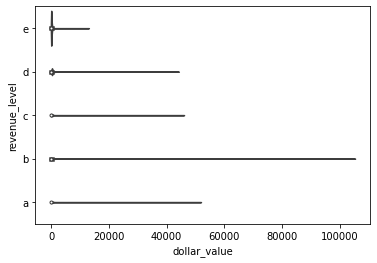

In [2]:
sns.violinplot(data=join_table, x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

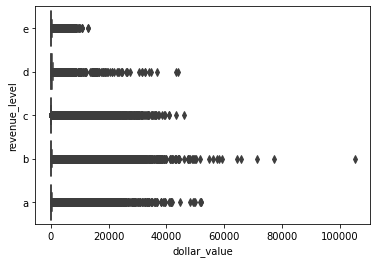

In [3]:
sns.boxplot(data=join_table, x="dollar_value", y="revenue_level")

<h4>3.1.1 Remove outliers based on standard deviation</h4>

In [4]:
rev_std = join_table.groupby("revenue_level").agg(
    dollar_value_std = ("dollar_value", "std"),
    dollar_value_mean = ("dollar_value", "mean")
    )
rev_std

,dollar_value_std,dollar_value_mean
revenue_level,,
a,360.364383,142.081137
b,594.247456,197.101671
c,434.419486,136.499838
d,681.020326,272.261558
e,399.062977,205.812128


In [5]:
total = join_table.count()
rev_sdf = join_table.join(rev_std, "revenue_level", "left")
rev_sdf = rev_sdf[(rev_sdf["dollar_value"] - rev_sdf["dollar_value_mean"]).abs() <= 3 * rev_sdf["dollar_value_std"]]
rev_sdf = rev_sdf.drop(columns=["dollar_value_mean", "dollar_value_std"])
print(f"Outliers based on revenue band removed: {total - rev_sdf.count()}")

Outliers based on revenue band removed: merchant_name        136394
products             136394
revenue_level        136394
take_rate            136394
dollar_value         136394
order_datetime       136394
consumer             136394
consumer_address     136394
consumer_state       136394
consumer_postcode    136394
consumer_gender      136394
dtype: int64


<h4>3.1.2 Check distribution</h4>

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

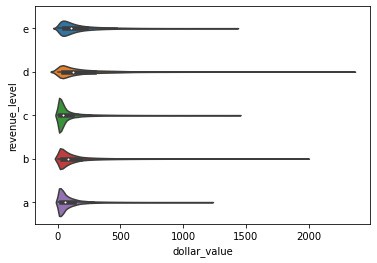

In [6]:
sns.violinplot(data=rev_sdf, x="dollar_value", y="revenue_level")

<AxesSubplot:xlabel='dollar_value', ylabel='revenue_level'>

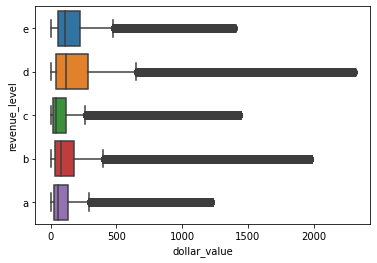

In [7]:
sns.boxplot(data=rev_sdf, x="dollar_value", y="revenue_level")

<h3>3.2 Get distribution of each merchant</h3>

In [8]:
merch_std = rev_sdf.groupby("merchant_name").agg(
    dollar_value_std = ("dollar_value", "std"),
    dollar_value_mean = ("dollar_value", "mean")
    )
merch_std

,dollar_value_std,dollar_value_mean
merchant_name,,
A Aliquet Ltd,141.762482,219.904272
A Arcu Industries,233.859461,377.450578
A Arcu Sed Company,95.385408,136.209245
A Arcu Sed Corporation,316.334103,597.254419
A Associates,224.465666,364.586060
...,...,...
Vulputate Ullamcorper Magna LLC,253.677912,387.763001
Vulputate Ullamcorper Magna Ltd,232.077650,347.513937
Vulputate Velit Eu Incorporated,298.997261,469.284910


In [9]:
total = rev_sdf.count()
merch_sdf = rev_sdf.join(merch_std, "merchant_name", "left")
merch_sdf = merch_sdf[(merch_sdf["dollar_value"] - merch_sdf["dollar_value_mean"]).abs() <= 3 * merch_sdf["dollar_value_std"]]
merch_sdf = merch_sdf.drop(columns=["dollar_value_mean", "dollar_value_std"])
print(f"Outliers based on merchant removed: {total - merch_sdf.count()}")

Outliers based on merchant removed: merchant_name        175062
products             175062
revenue_level        175062
take_rate            175062
dollar_value         175062
order_datetime       175062
consumer             175062
consumer_address     175062
consumer_state       175062
consumer_postcode    175062
consumer_gender      175062
dtype: int64


In [ ]:
merch_sdf.to_parquet("../data/curated/mechant_consumer_info")